# Probabilistic Programming 3: Hidden Markov modeling
## Monte Carlo sampling

In this notebook, we will be looking at forecasting a time-series. To be precise, we will implement a Hidden Markov Model using Turing.

### Preliminaries

- Goal 
  - Learn to apply Turing to a time-series data set.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - [Tutorial on Bayesian HMM using Turing.jl](https://turing.ml/dev/tutorials/4-bayeshmm/)
    - [Probabilistic Programming notebook](https://github.com/bertdv/BMLIP/tree/master/lessons/notebooks/probprog/Probabilistic-Programming.ipynb)
    - [Cheatsheets: how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [ ]:
# Package managing
using Pkg
Pkg.activate("workspace")
Pkg.instantiate()

include("../scripts/pp-3.jl")

using Logging; disable_logging(LogLevel(0))
using Distributions
using StatsPlots
using MCMCChains
using Turing
Turing.setadbackend(:forward_diff);

## Data generation

In this problem setting, data is generated in the form of states over time. For example, proteins that fold into one of several functional configurations or machine translation, where one observes writing in one language and aims to infer writing in another language (both being finite sets of symbols). We don't have perfect measurement tools and have to assume measurement noise. 

We will generate a synthetic data set as follows: we pick an initial state and evolve the state using a fixed state transition matrix. Then we observe the state using a fixed observation probability, referred to as an _emission_ matrix. 

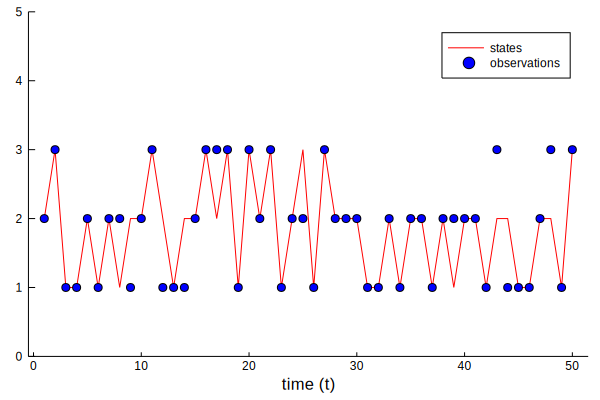

In [2]:
# There are 3 possible states and each variable is in one of those (one-hot encoding)
K = 3

# Length of time-series
T = 50

# Transition matrix of latent variables
transition = [0.3 0.6 0.1; 
              0.5 0.2 0.3; 
              0.2 0.7 0.1]

# Emission matrix for observed variables
emission = [0.9 0.1 0.0; 
            0.1 0.8 0.1; 
            0.0 0.2 0.8]

# Preallocate data arrays
states = Array{Int64,1}(undef, T)
observations = Array{Int64,1}(undef, T)

# Initial state
state_0 = 1

# Keep previous state in memory
state_tmin = state_0

# Generate data for entire time-series
for t = 1:T
    
    # Transition from previous state
    states[t] = rand(Categorical(transition[state_tmin, :]), 1)[1]
    
    # Emission of current state
    observations[t] = rand(Categorical(emission[states[t], :]), 1)[1]
    
    # Update previous state
    state_tmin = states[t]
    
end

# Visualization.
plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false)
scatter!(1:T, observations, color="blue", label="observations", xlabel="time (t)")

## Model specification

The Hidden Markov model is a state-space model of the form:

$$\begin{align}
x_t \sim&\ \text{Cat}(A x_{t-1}) \\
y_t \sim&\ \text{Cat}(B x_t)
\end{align}$$

where $A$ is the state transition matrix and $B$ is the emission matrix. The states $x$ are indexed by time $t$, ranging from $0$ to $T$. The observations $y$ are indexed from $1$ to $T$. 

Again, we start simple and slowly improve the model.

### Model 1: estimate states

We will first assume we know the transition and emission matrices. Based on these, we purely want to estimate states from observations.

In [3]:
# Turing model definition.
@model hidden_markov_model(y, K, A, B) = begin
    
    # Time series length
    T = length(y)

    # State sequence.
    x = Vector{Int}(undef, T)

    # Define initial state
    x_0 ~ Categorical(ones(K,)./K)
    
    # Initialize "previous state" variable
    x_tmin = x_0

    # Loop over entire sequence
    for t = 1:T
        
        # State transition     
        x[t] ~ Categorical(A[x_tmin, :])
        
        # Observation emission
        y[t] ~ Categorical(B[x[t], :])
        
        # Update previous state
        x_tmin = x[t]
    end
end;

# Call instance of the model
model1 = hidden_markov_model(observations, K, transition, emission);

The Categorical distribution is a known parametric distribution, which we can marginalize. It is therefore suited to Gibbs sampling.

In [4]:
# Length of chain
len_chain = 500

# Define sampler
sampler1 = Gibbs(PG(50, :x))

# Call sampler
chain1 = sample(model1, sampler1, len_chain);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:51


Let's inspect the chain again. Note that $x$ is an array of $T$ latent variables, so this would extend for a quite bit.Instead, we're going to inspect the last state.

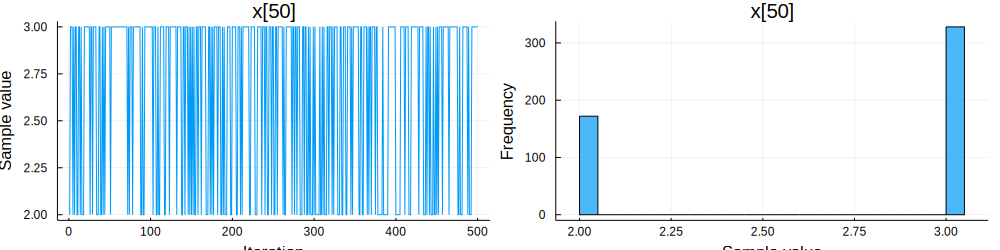

In [23]:
plot(chain1["x["*string(T)*"]"])

Since the state space is discrete, we cannot take the sample average of the chain to obtain estimates. The sample average is continuous, after all. To obtain discrete estimates, we take the median of the chain.

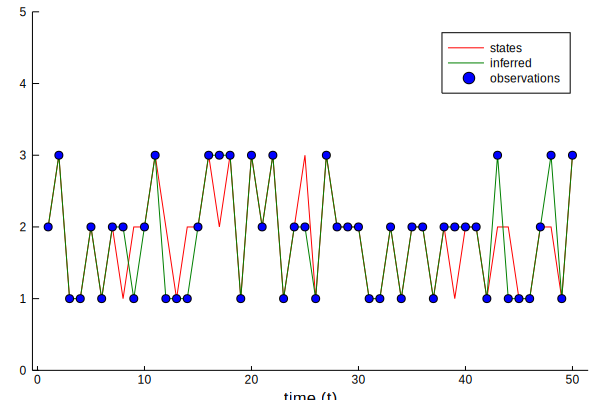

In [6]:
# Extract mean of chain
x_estimated = median_chain(chain1, :x)

# Visualization
plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false)
plot!(1:T, x_estimated, color="green", label="inferred")
scatter!(1:T, observations, color="blue", label="observations", xlabel="time (t)")

### Model 2: transition matrix estimation

At the moment, we assume we know how the states evolve over time. This is not an unreasonable assumption; in protein folding we know exactly _how_ the protein changes state, i.e. through the signaling of another molecule, and we know the concentration of signal molecules. However, in other applications we do not necessarily know the transition matrix. 

We can estimate the transition matrix by letting the coefficients be latent variables and posing a prior.

In [7]:
# Turing model definition.
@model hidden_markov_model(y, K, B) = begin
    
    # Time series length.
    T = length(y)

    # State sequence.
    x = Vector{Int}(undef, T)

    # Define initial state
    x_0 ~ Categorical(ones(K,)./K)
    
    # Initialize "previous state" variable
    x_tmin = x_0
    
    # Preallocate transition matrix
    A = Vector{Vector}(undef, K)
    
    # Loop over rows of the transition matrix
    for k = 1:K
        
        # Loose prior for state transitions
        A[k] ~ Dirichlet(ones(K))
    end

    # Loop over entire sequence
    for t = 1:T
        
        # State transition     
        x[t] ~ Categorical(A[x_tmin])
        
        # Observation emission
        y[t] ~ Categorical(B[x[t], :])
        
        # Update previous state
        x_tmin = x[t]
    end
end;

# Call instance of the model
model2 = hidden_markov_model(observations, K, emission);

We will extend the current sampler with a Hamiltonian MC for the transition matrix.

In [8]:
# Length of chain
len_chain = 500

# Define sampler
sampler2 = Gibbs(PG(50, :x), HMC(0.1, 5, :A))

# Call sampler
chain2 = sample(model2, sampler2, len_chain);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/wmkouw/.julia/packages/AdvancedHMC/haUrH/src/hamiltonian.jl:44
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/wmkouw/.julia/packages/AdvancedHMC/haUrH/src/hamiltonian.jl:44
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/wmkouw/.julia/packages/AdvancedHMC/haUrH/src/hamiltonian.jl:44
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, false)
└ @ AdvancedHMC /home/wmkouw/.julia/packages/AdvancedHMC/haUrH/src/hamiltonian.jl:44
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08


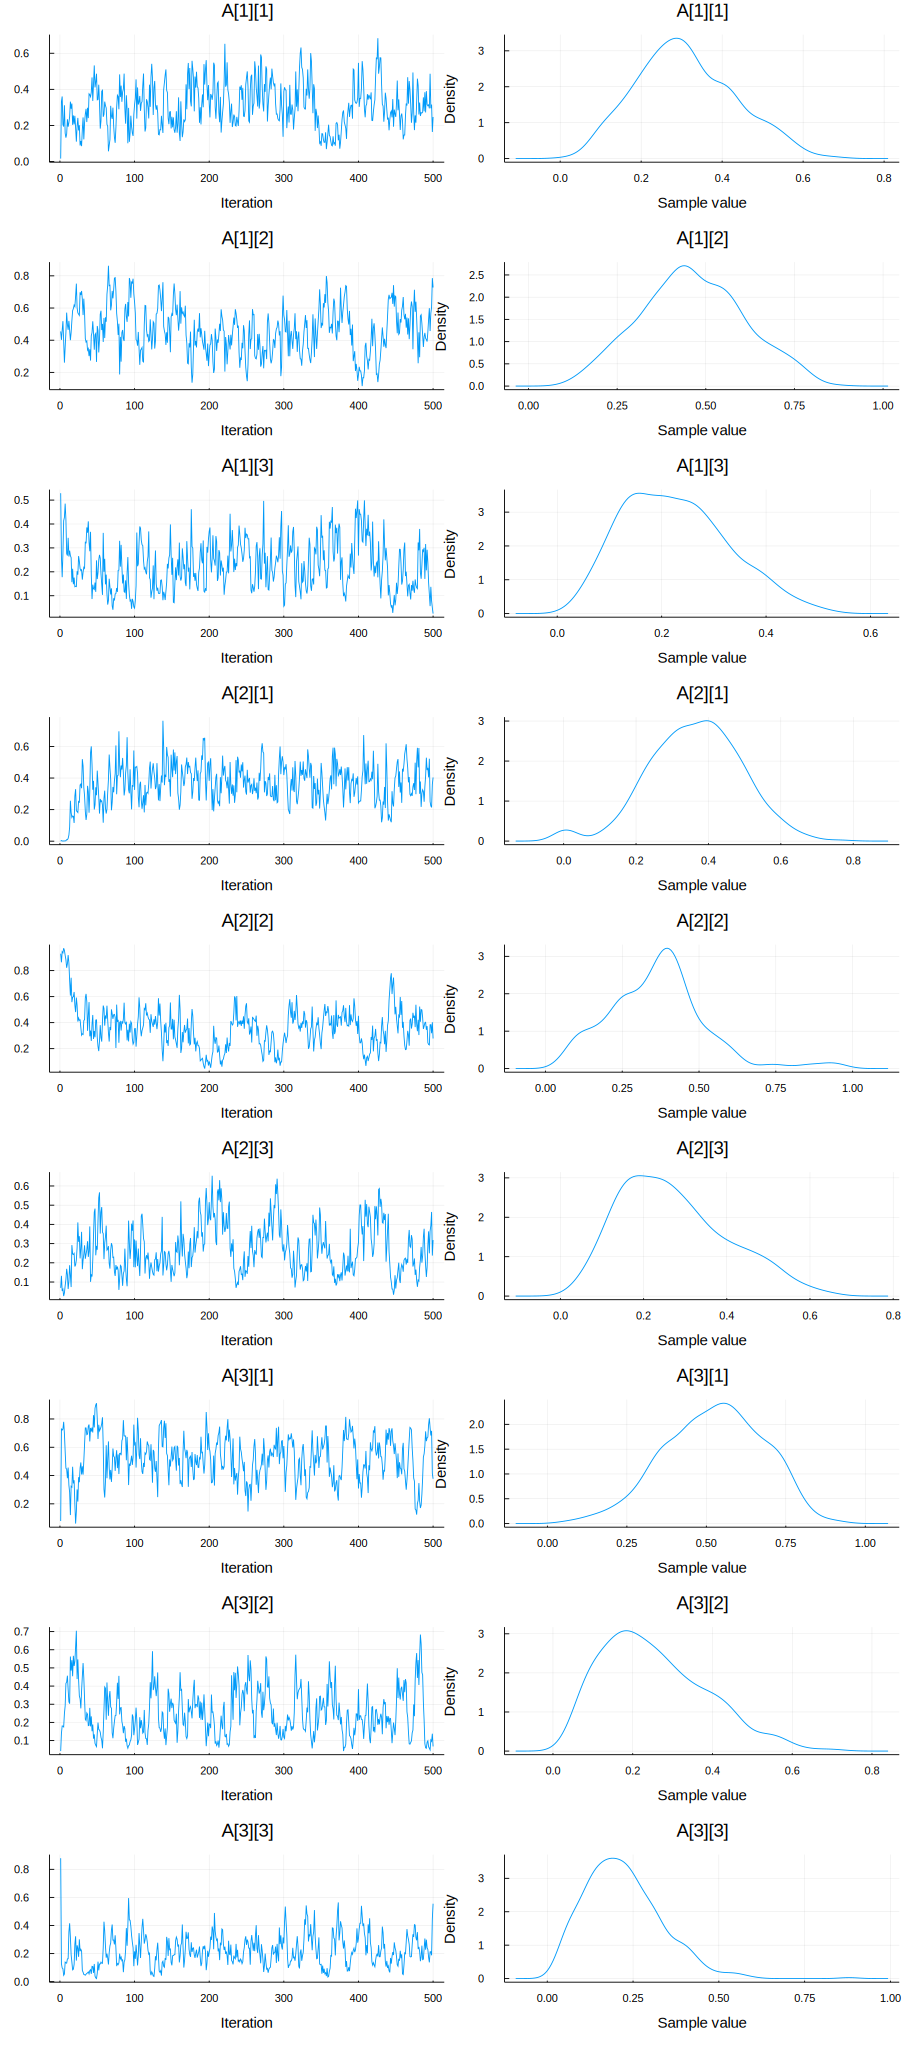

In [25]:
plot(chain2[:A])

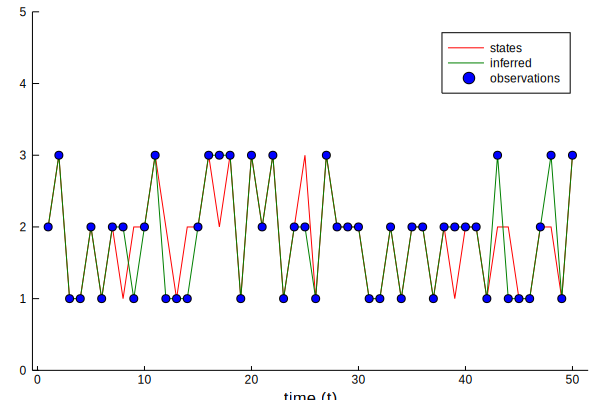

In [10]:
# Extract mean of chain
x_estimated = median_chain(chain2, :x)

# Visualization
plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false)
plot!(1:T, x_estimated, color="green", label="inferred")
scatter!(1:T, observations, color="blue", label="observations", xlabel="time (t)")

Let's visualize the estimated transition matrix.

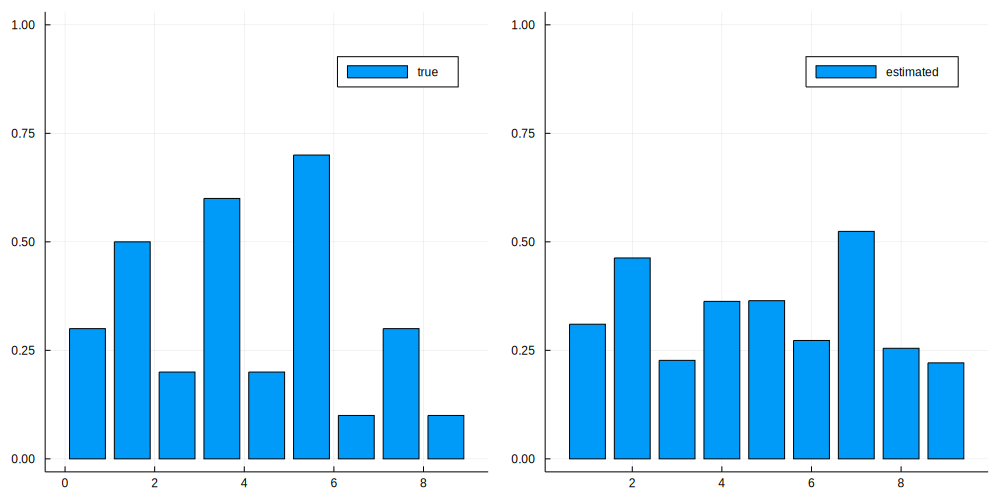

In [11]:
# Extract state estimates
transition_estimated = mean(chain2[:A].value.data[:,:,1], dims=1)

# Visualization
l = @layout [a b]
h1 = bar(0:9, reshape(transition, (9,)), label="true", ylims=[0., 1.])
h2 = bar(reshape(transition_estimated, (9,)), label="estimated", ylims=[0., 1.])
plot(h1, h2, layout=l, size=(1000,500))

### Model 3: states, transition and emission

We can extend the model further to also estimate the emission matrix. 

In [12]:
@model hidden_markov_model(y, K) = begin
    
    # Time series length.
    T = length(y)

    # State sequence.
    x = Vector{Int}(undef, T)

    # Define initial state
    x_0 ~ Categorical(ones(K,)./K)
    
    # Initialize "previous state" variable
    x_tmin = x_0
    
    # Preallocate transition and emission matrices
    A = Vector{Vector}(undef, K)
    B = Vector{Vector}(undef, K)
    
    # Loop over rows of the transition and emission matrices
    for k = 1:K
        
        # Loose prior for state transitions
        A[k] ~ Dirichlet(ones(K))
        
        # Sharper prior for emissions
        B[k] ~ Dirichlet(10*one_hot(k,K) .+ 1)
    end

    # Loop over entire sequence
    for t = 1:T
        
        # State transition     
        x[t] ~ Categorical(A[x_tmin])
        
        # Observation emission
        y[t] ~ Categorical(B[x[t]])
        
        # Update previous state
        x_tmin = x[t]
        
    end
end;

# Call instance of the model
model3 = hidden_markov_model(observations, K);

In [13]:
# Length of chain
len_chain = 500

# Define sampler
sampler3 = Gibbs(PG(50, :x), HMC(0.001, 2, :A, :B))

# Call sampler
chain3 = sample(model3, sampler3, len_chain);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:50


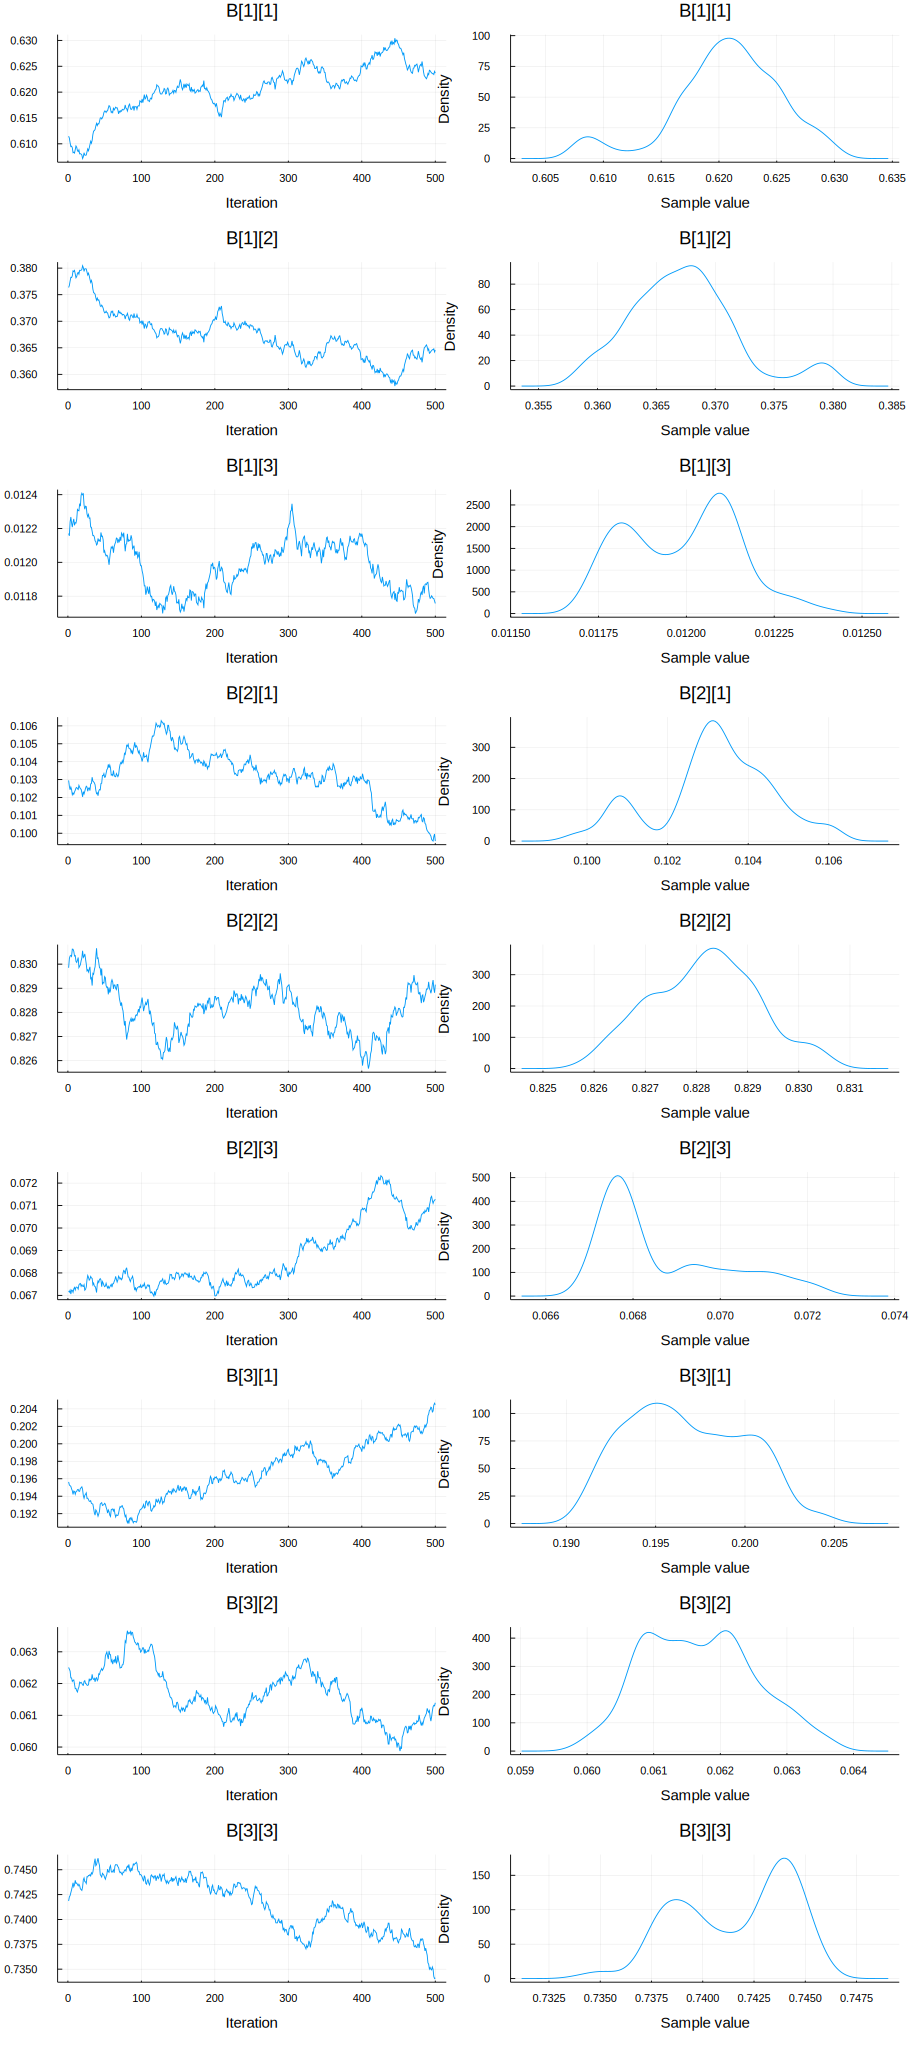

In [26]:
plot(chain3[:B])

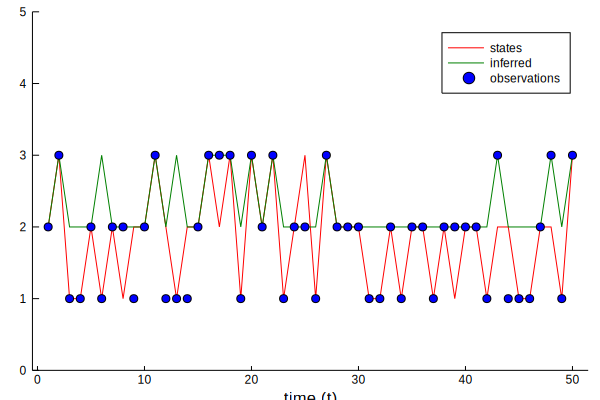

In [15]:
# Extract mean of chain
x_estimated = median_chain(chain3, :x)

# Visualization
plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false)
plot!(1:T, x_estimated, color="green", label="inferred")
scatter!(1:T, observations, color="blue", label="observations", xlabel="time (t)")

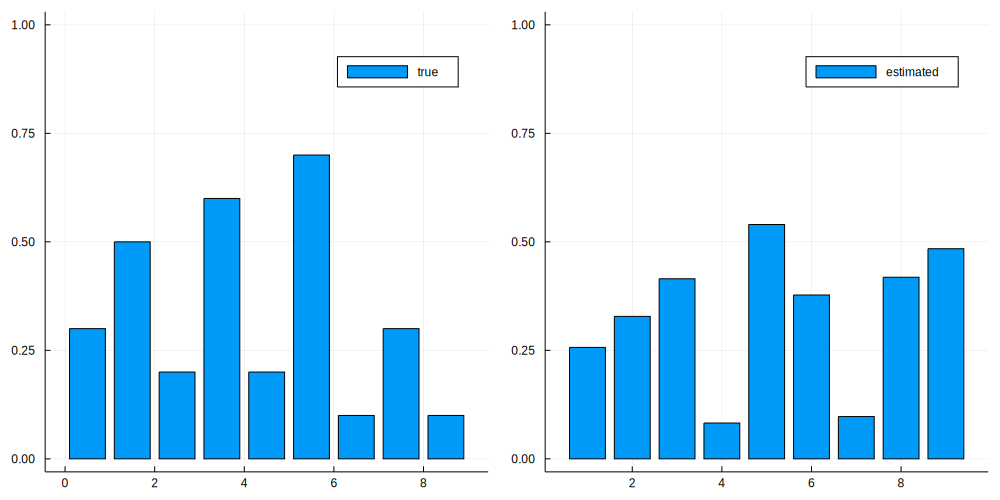

In [16]:
# Extract state estimates
transition_estimated = mean(chain3[:A].value.data[:,:,1], dims=1)

# Visualization
l = @layout [a b]
h1 = bar(0:9, reshape(transition, (9,)), label="true", ylims=[0., 1.])
h2 = bar(reshape(transition_estimated, (9,)), label="estimated", ylims=[0., 1.])
plot(h1, h2, layout=l, size=(1000,500))

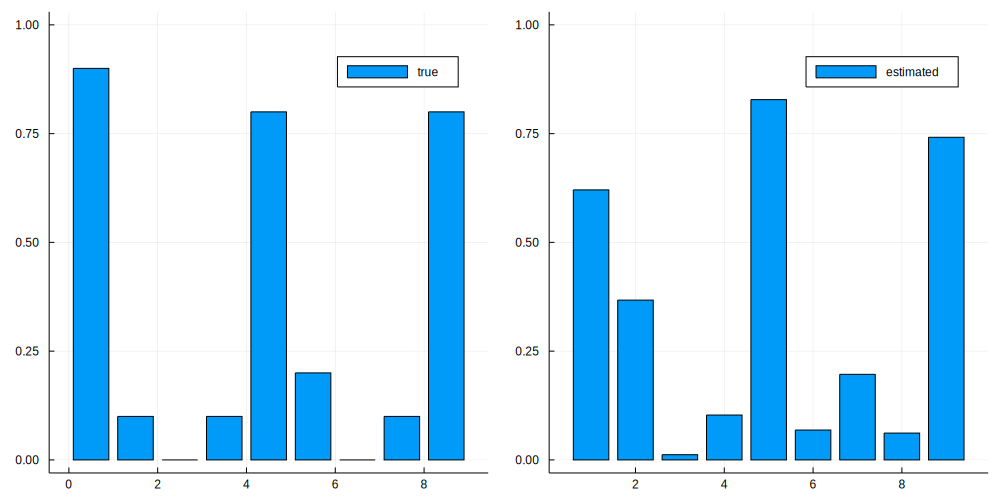

In [17]:
# Extract emission estimates
emission_estimated = mean(chain3[:B].value.data[:,:,1], dims=1)

# Visualization
l = @layout [a b]
h1 = bar(0:9, reshape(emission, (9,)), label="true", ylims=[0., 1.])
h2 = bar(reshape(emission_estimated, (9,)), label="estimated", ylims=[0., 1.])
plot(h1, h2, layout=l, size=(1000,500))

### Assignment: priors

Note that it becomes harder to identify whether an observation was noisily generated from one state or precisely generated from another state. Here, the prior can help: if we have some idea of how noisy the sensor is, but not exact enough to _fix_ the emission matrix to particular values, then we can still favor certain solutions over others.

Play around with the prior parameters of the state transition and emission matrices. How does the state estimation depend on the priors? Is this model more sensitive to the choice of priors than the mixture model or regression models?

In [ ]:
### Your code here

### Optional assignment: continuous observations

We can extend the problem setting to one where the states are discrete, but the observations are continuous. This type of problem occurs often. Think for example of speech recognition: each utterance belongs to a discrete finite set of syllables. The generative model is formulated as follows:

$$\begin{align} 
x_t \sim&\ \text{Cat}(A x_{t-1}) \\
y_t \sim&\ \mathcal{N}(x_t, \sigma)
\end{align}$$

with the customary $x_0 \sim \text{Cat}(1/K)$. We've provided the data generation setup below:

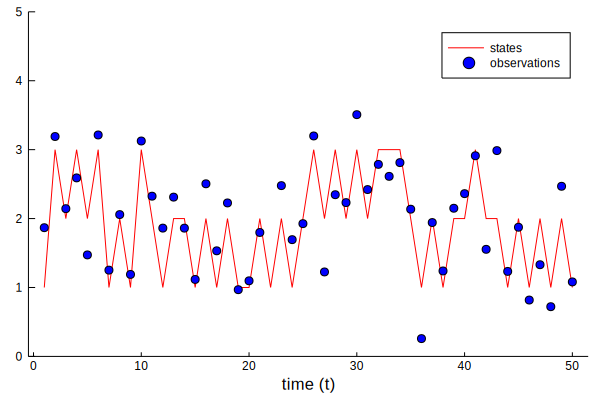

In [19]:
# There are 3 possible states and each variable is in one of those (one-hot encoding)
K = 3

# Length of time-series
T = 50

# Transition matrix of latent variables
transition = [0.3 0.6 0.1; 
              0.5 0.2 0.3; 
              0.2 0.7 0.1]

# Measurement noise for observations y
measurement_noise = 1/2

# Preallocate data arrays
states = Array{Int64,1}(undef, T)
observations = Array{Float64,1}(undef, T)

# Initial state
state_0 = 1

# Keep previous state in memory
state_tmin = state_0

# Generate data for entire time-series
for t = 1:T
    
    # Transition from previous state
    states[t] = rand(Categorical(transition[state_tmin, :]), 1)[1]
    
    # Emission of current state
    observations[t] = rand(Normal(states[t], measurement_noise), 1)[1]
    
    # Update previous state
    state_tmin = states[t]
    
end

# Visualization.
plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false)
scatter!(1:T, observations, color="blue", label="observations", xlabel="time (t)")

Can you change the model such that it infers the discrete states from continuous observations?

In [ ]:
### Your code here